# Compare Ship and Satellite SST

In [85]:
import os
import glob
from importlib import reload

import numpy as np

import xarray
import pandas
import healpy

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
import seaborn as sns

from remote_sensing.healpix import rs_healpix
from remote_sensing.plotting import utils as plot_utils

import ship

In [2]:
lon_lim = (127.,134)
lat_lim = (18.,23)

# Grab Satellite data

In [26]:
reload(rs_healpix)
amsr2_file = os.path.join(os.getenv('OS_RS'), 'PODAAC', 'AMSR2-REMSS-L2P_RT-v8.2', 
                          '20250214041351-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r67797-v02.0-fv01.0.nc')
amsr2 = rs_healpix.RS_Healpix.from_dataset_file(amsr2_file,  'sea_surface_temperature',
            time_isel=0, resol_km=11., 
            lat_slice=(18,23.),  lon_slice=(127., 134.))

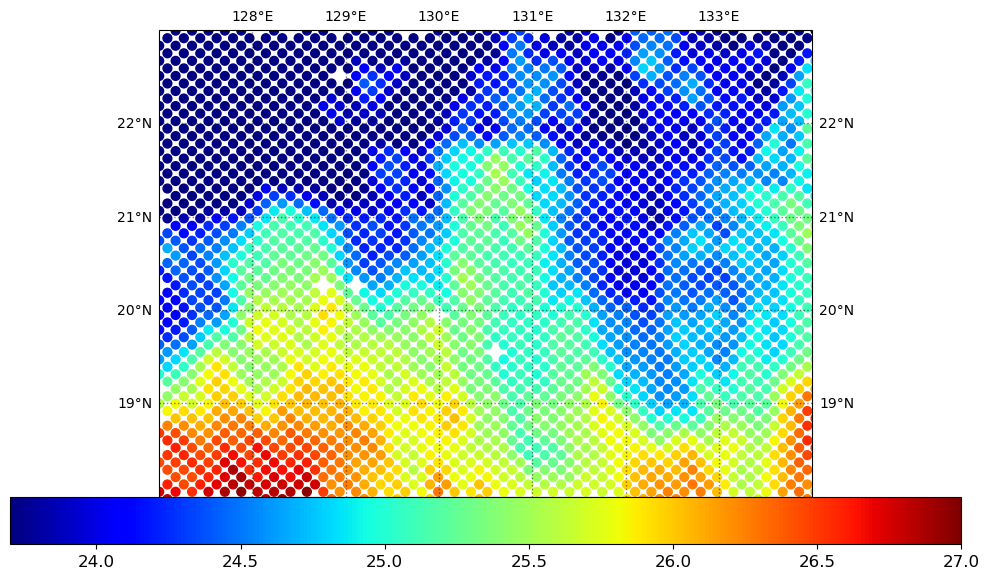

(<GeoAxes: >, <matplotlib.collections.PathCollection at 0x71076b4627e0>)

In [4]:
amsr2.plot(figsize=(10.,6), cmap='jet', 
        lon_lim=lon_lim, lat_lim=lat_lim, 
        projection='platecarree', ssize=40., 
        vmin=23.7, vmax=27., show=True)

# Load ship data

In [11]:
def load_ship(tlims=None):
    import system_config as sys_cfg
    cruiseshare_path = sys_cfg.get_path('cruiseshare')
    def preprocess(ds):
        ds = ds.sortby('time')
        ds = ds.drop_duplicates('time')
        # drop dat with t<2020
        ds = ds.sel(time=ds.time.dt.year > 2020)
        return ds

    fname = f'{cruiseshare_path}/Data/ship/ship.2025*.nc'
    # files = glob.glob(fname)
    # files.sort()
    # files = files[1:]
    # ship = xr.open_mfdataset(files, combine='by_coords', preprocess=preprocess).load() 
    with xarray.open_mfdataset(fname, combine='by_coords', 
                           preprocess=preprocess) as ship:
        if tlims is not None:
            ship = ship.sel(time=slice(*tlims))
            loaded_ship = ship.load()
            ship.close()
        else:
            loaded_ship = ship
    return loaded_ship

In [13]:
ship_data = load_ship()

In [32]:
ship_data.temperatureInlet

<xarray.DataArray 'temperatureInlet' (time: 1543485)> Size: 6MB
dask.array<concatenate, shape=(1543485,), dtype=float32, chunksize=(1055,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12MB 2025-01-29 ... 2025-02-15T20:45:10
Attributes:
    units:      degC
    long_name:  temperature_at_inlet

# Match up

In [27]:
amsr2.time

Timestamp('2025-02-14 04:13:51')

In [60]:
ship_t = pandas.to_datetime(ship_data.time)
dt = ship_t - amsr2.time
close_t = np.abs(dt) < pandas.Timedelta('2 hours')
np.sum(close_t)

np.int64(14399)

# Temperatures

## Calculate from AMSR2

In [67]:
ship_lons, ship_lats = ship_data.lon.values[close_t], ship_data.lat.values[close_t] 

In [62]:
amsr2T_at_ship = healpy.pixelfunc.get_interp_val(
            amsr2.hp, ship_lons, ship_lats, lonlat=True)

In [70]:
DT = ship_data.temperatureInlet[close_t].values - amsr2T_at_ship

# Plot me

In [72]:
def timedelta_to_hours(x, pos):
    # Convert timedelta in nanoseconds to hours
    return x / (1e9 * 3600)

In [80]:
x_hours

Index([-1.9997222222222222, -1.9994444444444444, -1.9991666666666668,
        -1.998888888888889, -1.9986111111111111, -1.9983333333333333,
       -1.9980555555555555, -1.9977777777777779,             -1.9975,
       -1.9972222222222222,
       ...
        1.9972222222222222,              1.9975,  1.9977777777777779,
        1.9980555555555555,  1.9983333333333333,  1.9986111111111111,
         1.998888888888889,  1.9991666666666668,  1.9994444444444444,
        1.9997222222222222],
      dtype='float64', length=14399)

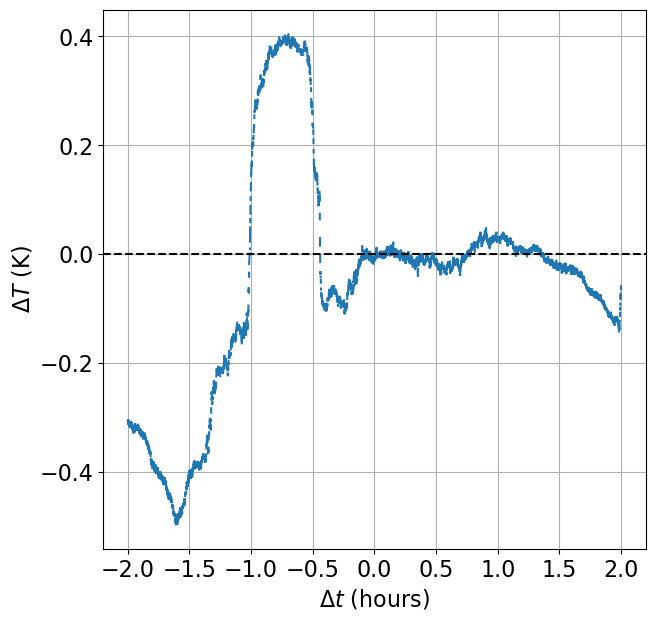

Mean DT = -0.047509115417965986


In [87]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()

x_hours = dt[close_t].total_seconds() / 3600

ax.plot(x_hours, DT)
#
ax.axhline(0., color='k', ls='--')
ax.set_xlabel(r'$\Delta t$ (hours)')
ax.set_ylabel(r'$\Delta T$ (K)')
#ax.xaxis.set_major_formatter(FuncFormatter(timedelta_to_hours))

plot_utils.set_fontsize(ax, 16.)
ax.grid()

plt.show()
#
print(f'Mean DT = {np.nanmean(DT)}')


## Plot the ship

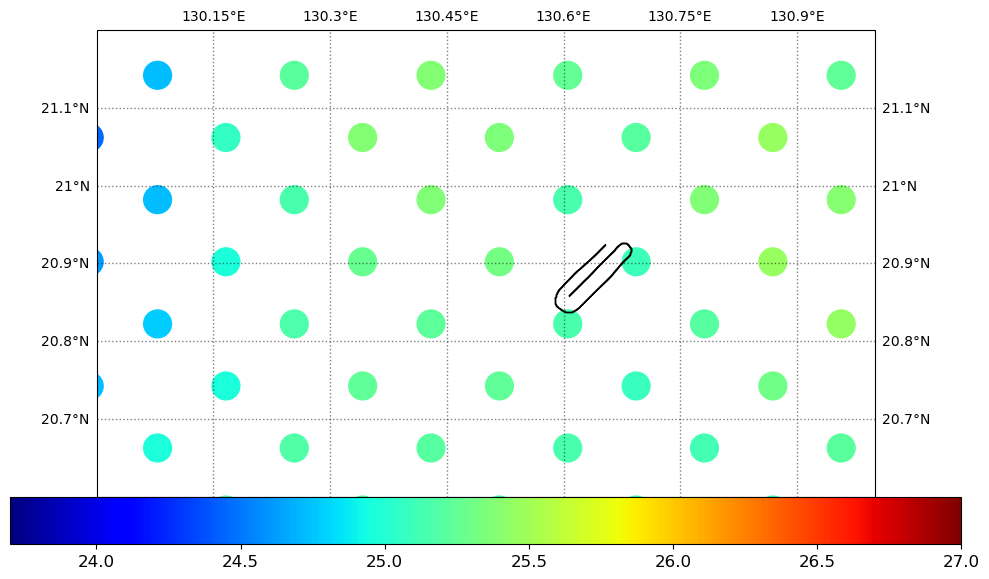

In [91]:
ax, img = amsr2.plot(figsize=(10.,6), cmap='jet', 
        lon_lim=(130.,131.), lat_lim=(20.6,21.2),
        projection='platecarree', ssize=400., 
        vmin=23.7, vmax=27., show=False)
# Add ship
ax.plot(ship_lons, ship_lats, 'x', color='k', ms=0.1)
#
plt.show()